In [1]:
from diffusers import StableDiffusionXLPipeline
import torch
from PIL import Image
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline
import json
from transformers import CLIPVisionModelWithProjection
from utils import image_grid
import numpy as np

In [2]:
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
#model_id = "wangqixun/YamerMIX_v8"
#model_id = '/amax/hchuz/hfd_models/RealVisXL_V5.0'
ip_adapter_path = '/amax/hchuz/DC-Master/ckpt/ip-adapter/sdxl'
device = 'cuda:7'

In [3]:
#controlnet_path = 'thibaud/controlnet-openpose-sdxl-1.0'
controlnet_path = '/amax/hchuz/hfd_models/controlnet-depth-sdxl-1.0'
controlnet = ControlNetModel.from_pretrained(controlnet_path, 
                                             torch_dtype=torch.float16,
                                             variant="fp16",
                                             use_safetensors=True,)#.to('cuda')
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(model_id, controlnet=controlnet, torch_dtype=torch.float16,)
#pipe = StableDiffusionXLControlNetPipeline.from_pretrained(model_id, controlnet=controlnet, torch_dtype=torch.float16, variant="fp16", use_safetensors=True)
pipe.load_ip_adapter(pretrained_model_name_or_path_or_dict = ip_adapter_path,
                     subfolder = '.', 
                     image_encoder_folder="vit_h",
                     weight_name =['ip-adapter-plus_sdxl_vit-h.bin', 'ip-adapter_sdxl_vit-h.bin'])

_ = pipe.to(device)
#pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

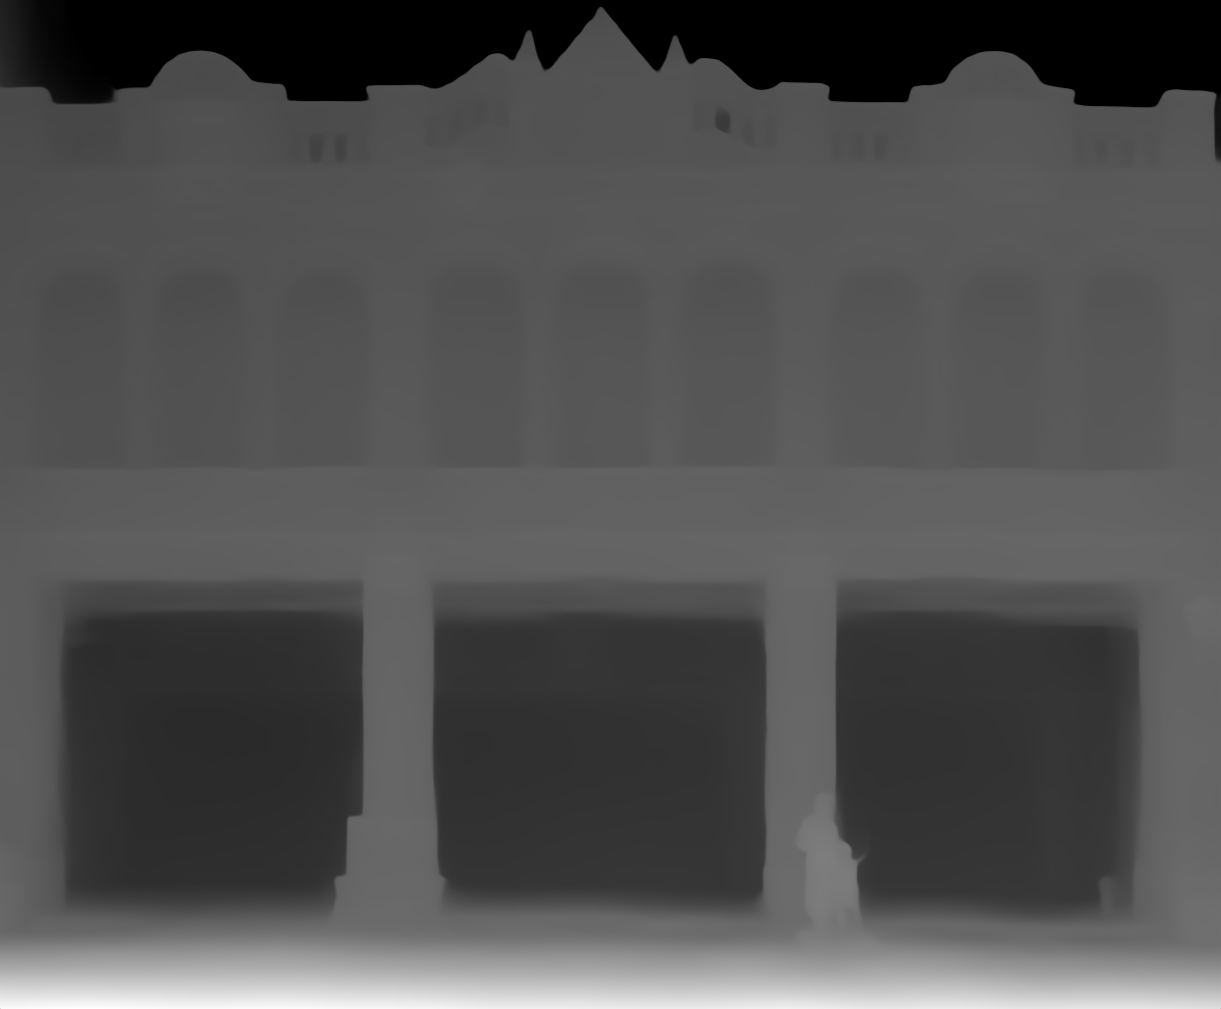

In [4]:
depth = Image.open('/amax/hchuz/architectural_heritage/temp/Snipaste_2023-02-21_13-33-06_depth.png')
depth

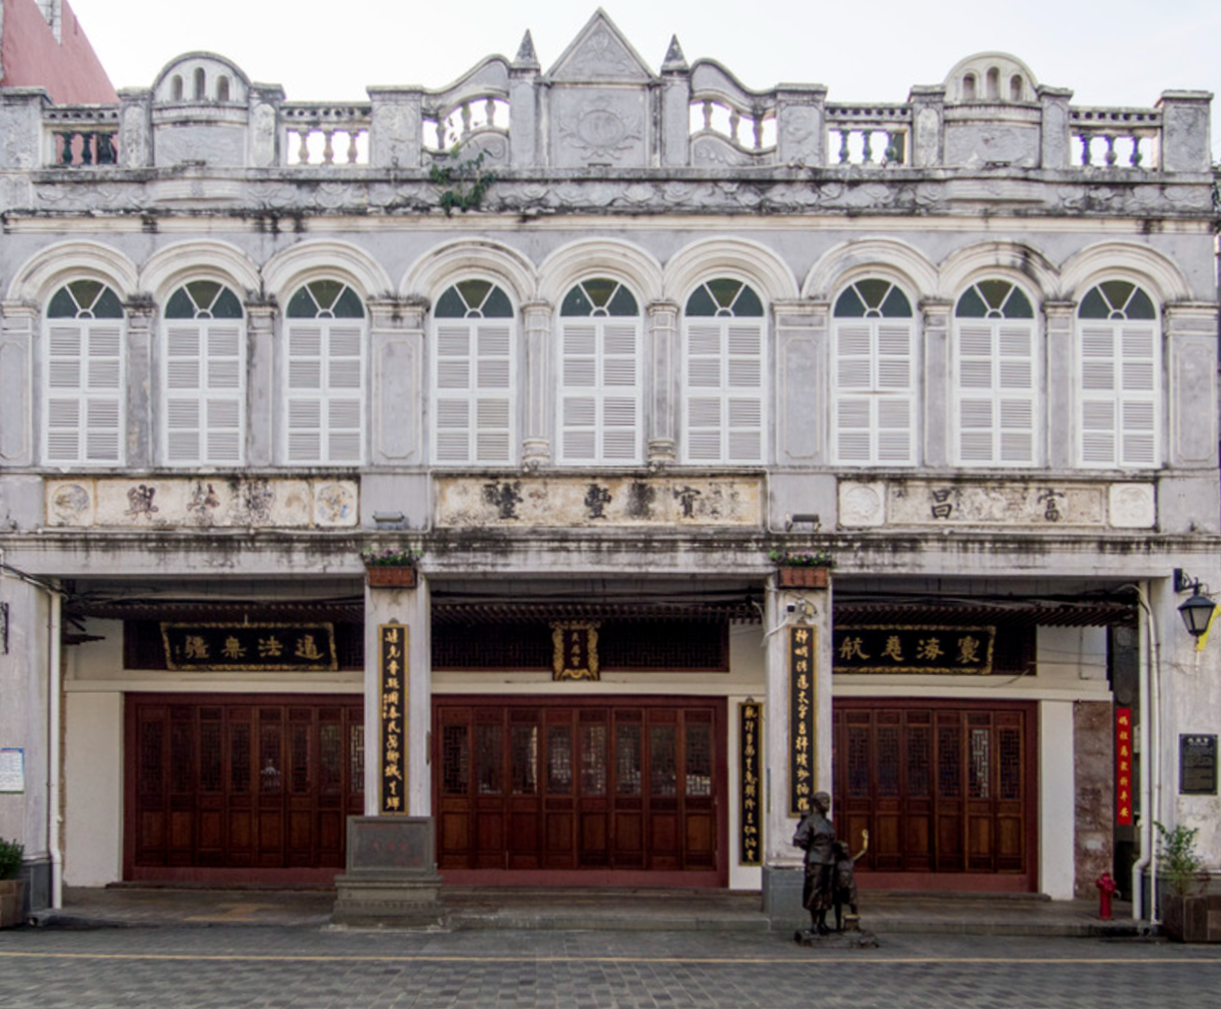

In [5]:
image = Image.open('/amax/hchuz/architectural_heritage/相似的几个2/Snipaste_2023-02-21_13-33-06.png').convert('RGB')
image

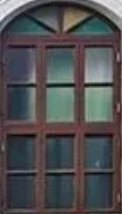

In [6]:
region = Image.open('/amax/hchuz/architectural_heritage/temp/Snipaste_2023-02-21_13-33-51_window.png')
region_mask = Image.open('/amax/hchuz/architectural_heritage/temp/Snipaste_2023-02-21_13-33-06_window_mask.png')
region

In [7]:
mask2 = torch.from_numpy(np.array(region_mask)).bool().unsqueeze(0).unsqueeze(0)
mask1 = ~mask2

In [8]:
ip_adapter_masks = [mask1.float(), mask2.float()]

In [15]:
pipe.set_ip_adapter_scale([1.0, 1.0])

  0%|          | 0/50 [00:00<?, ?it/s]

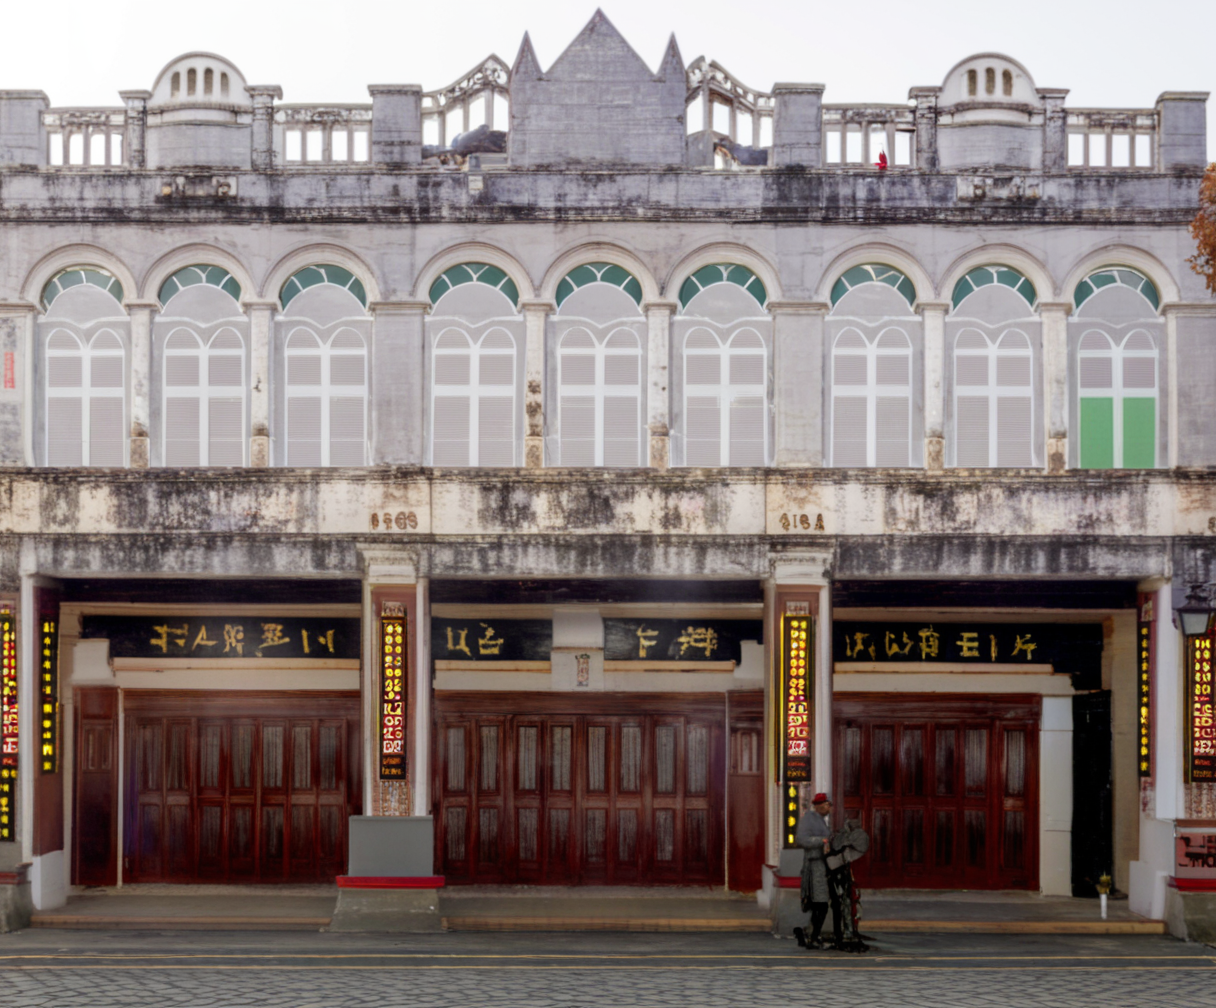

: 

In [ ]:
prompt = "high quality"
negative_prompt = "human, low quality, bad quality"
seed = 42
images = pipe(prompt=prompt,
              ip_adapter_image = [image, region],
              negative_prompt = negative_prompt,
              image = depth,
              num_inference_steps=50,
              #negative_prompt=negative_prompt,
              #num_images_per_prompt=1
              cross_attention_kwargs={"ip_adapter_masks": ip_adapter_masks},
              generator = torch.Generator(device).manual_seed(seed)
              )[0]
images[0]